# Medicare Claims Data Analysis Project Goals:

* Create and call at least 3 functions, at least one of which must return a value that is used

* Calculate and display data based on an external factor

* Connect to an external/3rd party API and read data into your app

* Analyze text/data and display information about it (ex: how many words in a paragraph)

* Visualize data in a graph, chart, or other visual representation of data


In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

# pd.set_option('display.max_rows', None)

## Create and call at least 3 functions, at least one of which must return a value that is used
* The below cell will run everything we need to format and consolidate our data that we will be using for all three years.
* The functions will be used to: 
    * make the API call 
    * add and format columns from existing data
    * aggregate data by HCPCS Code (so there are no duplicates in each year) 
    * create two "delta" dataframes that track year-to-year changes
    * help format the delta dataframes and master dataframe by reinserting the index and recovering the "HCPCS Code" column.
    * total the year columns for a specific data point (i.e. total number of services for all 3 years) and return a sorted dataframe with just that data, the code and description to be used for plotting.
    
## Calculate and display data based on an external factor.
* "add_totals_columns" function makes use of calculations within the returned data. For example, the total billed amount of a procedure is calculated by multiplying the "number of services" value by the "average medicare allowed amount" originally present in the data. 
* Three such calculations are used in this function, and these columns will provide the most useful data for our analysis.

In [2]:
### ALL FUNCTIONS

# Function that will retrieve raw data that can be read into dataframe.
def get_api_data(url):
    request = requests.get(url)
    return request.content


# Function that will add columns needed for each dataframe that can be used for further analysis.
def add_totals_columns (df, year):
    df["total_billed_amount"] = df["number_of_services"] * df["average_medicare_allowed_amount"]
    df["total_amount_paid"] = df["number_of_services"] * df["average_medicare_payment_amount"]
    df["total_cost_to_patient"] = df["number_of_services"] * (df["average_medicare_allowed_amount"] - df["average_medicare_payment_amount"])
    return df


# Function that will aggregate data, allowing combination of data by HCPCS code to eliminate multiple codes in data set.
def aggregate_data(df):
    aggregation_instructions = {'hcpcs_description': 'first',
                            'hcpcs_drug_indicator': 'first',
                            'number_of_providers': 'sum',
                            'number_of_services' : 'sum',
                            'number_of_distinct_medicare_beneficiary_per_day_services': 'sum',
                            'average_submitted_charge_amount': 'mean',
                            'average_medicare_allowed_amount': 'mean',
                            'average_medicare_payment_amount': 'mean',
                            'total_billed_amount': 'sum',
                            'total_amount_paid': 'sum',
                            'total_cost_to_patient': 'sum',                         
                           }
    return df.groupby('hcpcs_code').aggregate(aggregation_instructions)


# Function using outer join to gather information regarding changes (delta) from year to year.
# fillna() method allows us to fill in all "NaN" or "<NA>" data so we can add/subtract data properly.    
def get_delta(df1, df2):
    join = pd.merge(df1, df2, how = 'outer', on=['hcpcs_code'])

    join = join[['number_of_services_x', 
                 'total_billed_amount_x', 
                 'total_amount_paid_x',
                 'total_cost_to_patient_x',
                 'number_of_services_y',
                 'total_billed_amount_y',
                 'total_amount_paid_y',
                 'total_cost_to_patient_y'
                ]].fillna(0)

    join['number_of_services_delta'] = join['number_of_services_x'] - join['number_of_services_y']
    join['total_billed_amount_delta'] = join['total_billed_amount_x'] - join['total_billed_amount_y']
    join['total_amount_paid_delta'] = join['total_amount_paid_x'] - join['total_amount_paid_y']
    join['total_cost_to_patient_delta'] = join['total_cost_to_patient_x'] - join['total_cost_to_patient_y']
                                                                                 
    return join[['number_of_services_delta', 
                 'total_billed_amount_delta', 
                 'total_amount_paid_delta',
                 'total_cost_to_patient_delta'
               ]]


# Function to use after join on HCPCS Codes that will re-establish index for easier slicing while retaining 'hcpcs_code' column.
def get_new_index(df):
    codes = df.index
    codes = codes.astype(int)
    index = np.array(list(range(0,len(df))))
    new_df = df.set_index(index)
    new_df.insert(0, 'hcpcs_code', codes)
    
    return new_df


# Function used to get a total from all three years for a specific data point and return a sorted dataframe with just that data for plotting purposes.
def sort_by_total (df, col_list, new_col):
    new_df = df
    new_df_prime = new_df [col_list].fillna(0)
    new_df[col_list] = new_df_prime[col_list]
    new_df[new_col] = (new_df[col_list[0]] + new_df[col_list[1]] + new_df[col_list[2]])
    col_list.insert(0, 'HCPCS Code')
    col_list.insert(1, 'Code Description')
    new_df = new_df.sort_values(by=[new_col], ascending=False)[col_list]
    return new_df

## Connect to an external/3rd party API and read data into your app

### Medicare Data Set of Surgical HCPCS Codes Reported on Claims, 2015-2017

* CMS API Endpoint, 2015: https://data.cms.gov/resource/uqfq-w9cg.json
* CMS API Endpoint, 2016: https://data.cms.gov/resource/jtra-d83c.json
* CMS API Endpoint, 2017: https://data.cms.gov/resource/2zuc-y5mm.json
* API Documentation, 2015: https://dev.socrata.com/foundry/data.cms.gov/uqfq-w9cg
* API Documentation, 2016: https://dev.socrata.com/foundry/data.cms.gov/jtra-d83c
* API Documentation, 2017: https://dev.socrata.com/foundry/data.cms.gov/2zuc-y5mm
* Was able to use documentation to format the below SoQL queries within my URLs to return a specific set of codes (10004 and 69990 - Surgical Codes).

In [3]:
# API Calls
df_2015 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/uqfq-w9cg.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2015)
df_2016 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/jtra-d83c.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2016)
df_2017 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/2zuc-y5mm.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2017)

In [4]:
# Using Functions to return main dataframe with all data and "delta" dataframes of year-to-year changes.

df_2015_agg = aggregate_data(df_2015)
df_2016_agg = aggregate_data(df_2016)
df_2017_agg = aggregate_data(df_2017)

d2016 = get_delta(df_2016_agg, df_2015_agg)
delta2016 = get_new_index(d2016)

d2017 = get_delta(df_2017_agg, df_2016_agg)
delta2017 = get_new_index(d2017)


frames = [df_2015_agg, df_2016_agg, df_2017_agg]
df = reduce(lambda  left,right: pd.merge(left,right,on=['hcpcs_code'], how='outer'), frames)
df = get_new_index(df)

# Formatting main dataframe columns for easier use.

descriptions = df['hcpcs_description_y']
descriptions2 = df['hcpcs_description']
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions)
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions2)

drug_indicator = df['hcpcs_drug_indicator_y']
drug_indicator2 = df['hcpcs_drug_indicator']
df['hcpcs_drug_indicator_x'] = df['hcpcs_drug_indicator_x'].fillna(drug_indicator)
df['hcpcs_drug_indicator_x'] = df['hcpcs_drug_indicator_x'].fillna(drug_indicator2)

df = df.drop([
    'number_of_distinct_medicare_beneficiary_per_day_services_x',
    'average_submitted_charge_amount_x',
    'hcpcs_description_y',
    'hcpcs_drug_indicator_y',
    'number_of_distinct_medicare_beneficiary_per_day_services_y',
    'average_submitted_charge_amount_y',
    'hcpcs_description',
    'hcpcs_drug_indicator',
    'number_of_distinct_medicare_beneficiary_per_day_services',
    'average_submitted_charge_amount'    
], axis=1)

df = df.rename(columns = {
    'hcpcs_code': "HCPCS Code",
    'hcpcs_description_x': 'Code Description',
    'hcpcs_drug_indicator_x': 'Drug Indicator',
    'number_of_providers_x': 'Number of Providers - 2015',
    'number_of_services_x': 'Number of Services - 2015',
    'average_medicare_allowed_amount_x': 'Average Allowed Amount - 2015',
    'average_medicare_payment_amount_x': 'Average Payment Amount - 2015',
    'total_billed_amount_x': 'Total Billed Amount - 2015',
    'total_amount_paid_x': 'Total Amount Paid - 2015',
    'total_cost_to_patient_x': 'Total Cost to Patient - 2015',
    'number_of_providers_y': 'Number of Providers - 2016',
    'number_of_services_y': 'Number of Services - 2016',
    'average_medicare_allowed_amount_y': 'Average Allowed Amount - 2016',
    'average_medicare_payment_amount_y': 'Average Payment Amount - 2016',
    'total_billed_amount_y': 'Total Billed Amount - 2016',
    'total_amount_paid_y': 'Total Amount Paid - 2016',
    'total_cost_to_patient_y': 'Total Cost to Patient - 2016',
    'number_of_providers': 'Number of Providers - 2017',
    'number_of_services': 'Number of Services - 2017', 
    'average_medicare_allowed_amount': 'Average Allowed Amount - 2017',
    'average_medicare_payment_amount': 'Average Payment Amount - 2017',
    'total_billed_amount': 'Total Billed Amount - 2017',
    'total_amount_paid': 'Total Amount Paid - 2017',
    'total_cost_to_patient': 'Total Cost to Patient - 2017'
})

## Analyze text/data, display information and visualize data

### What questions can I use this data set to answer?

* What surgical procedures were most common in from 2015-2017?
* What surgical procedures, overall, cost Medicare the most?
* What procedures were least covered (i.e. where discrepancy between charges and amount paid was greatest).
* What are the biggest trends and changes from year to year?
* What types of procedures are most common (can organize by specialty or by surgery method, etc.)

HCPCS Code,Code Description,Number of Services - 2015,Number of Services - 2016,Number of Services - 2017
36415,Insertion of needle into vein for collection of blood sample,52243551,51485177,50090087
17003,Destruction of 2-14 skin growths,17584196,18353119,18584883
66984,Removal of cataract with insertion of lens,8407911,8905534,8957299
11721,Removal of tissue from 6 or more finger or toe nails,7486153,7360840,7198874
20610,Aspiration and/or injection of large joint or joint capsule,5653385,5846725,5840974
17000,Destruction of skin growth,5497121,5718790,5795860
11100,Biopsy of single growth of skin and/or tissue,3313033,3460648,3536383
67028,Injection of drug into eye,2750186,2970122,3113696
11720,Removal of tissue from 1 to 5 finger or toe nails,2115115,2131774,2110681
17110,Destruction of up to 14 skin growths,1966419,2140586,2234691


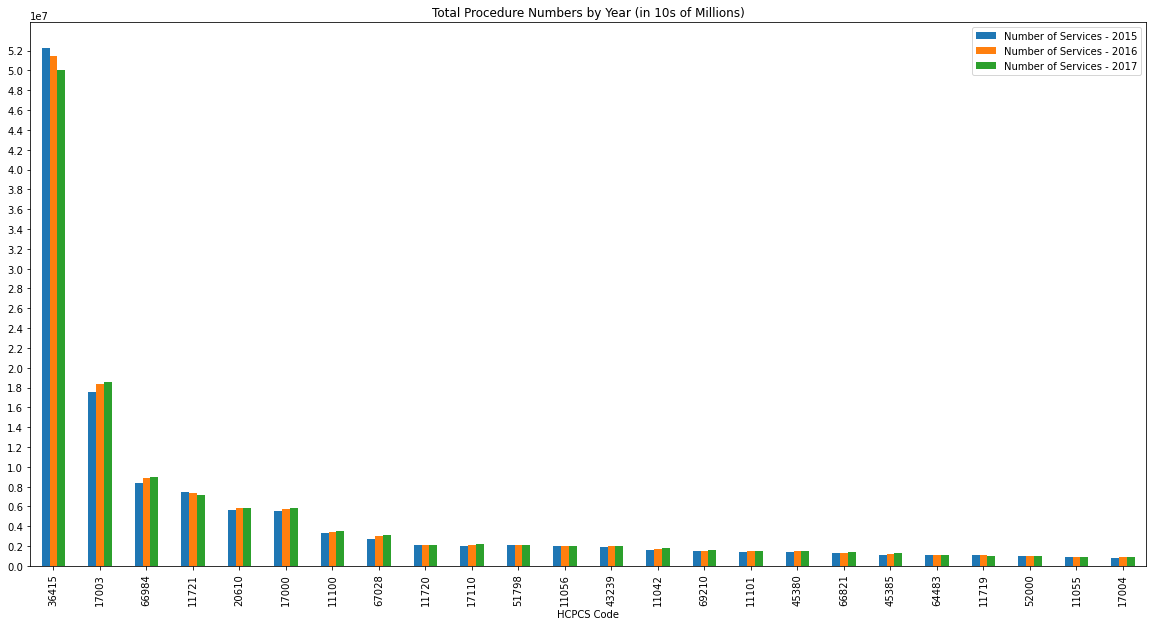

In [6]:
# What surgical procedures were most common from 2015-2017?

number_of_services_columns = ['Number of Services - 2015', 'Number of Services - 2016', 'Number of Services - 2017']
df_by_count = sort_by_total(df, number_of_services_columns, 'Total Number of Services')

y_axis = np.arange(0,52000001, 2000000)
df_by_count[0:24].plot.bar(
    x = "HCPCS Code", 
    title = "Total Procedure Numbers by Year (in 10s of Millions)", 
    yticks = y_axis, 
    figsize = (20, 10)
)

df_by_count[0:24].style.hide_index()

HCPCS Code,Code Description,Total Amount Paid - 2015,Total Amount Paid - 2016,Total Amount Paid - 2017
66984,Removal of cataract with insertion of lens,1664576248.440000,1735582260.430000,1751800510.660000
27447,Repair of knee joint,319611027.700000,341983103.760000,348756357.590000
45385,Removal of polyps or growths of large bowel using an endoscope,306110937.720000,298353556.320000,321721636.900000
17311,"Removal and microscopic examination of growth of the head, neck, hands, feet, or genitals (first stage, up to 5 tissue blocks)",284742542.240000,308870160.440000,321219024.110000
45380,Biopsy of large bowel using an endoscope,280081469.850000,251452245.950000,265863835.970000
43239,"Biopsy of the esophagus, stomach, and/or upper small bowel using an endoscope",263397761.840000,265822782.800000,250318014.210000
20610,Aspiration and/or injection of large joint or joint capsule,248330232.550000,253887398.710000,255809476.920000
67028,Injection of drug into eye,221050953.940000,239387319.060000,251108099.200000
11721,Removal of tissue from 6 or more finger or toe nails,237473748.080000,230878749.960000,223958229.450000
11100,Biopsy of single growth of skin and/or tissue,224171836.750000,227845101.400000,230840916.130000


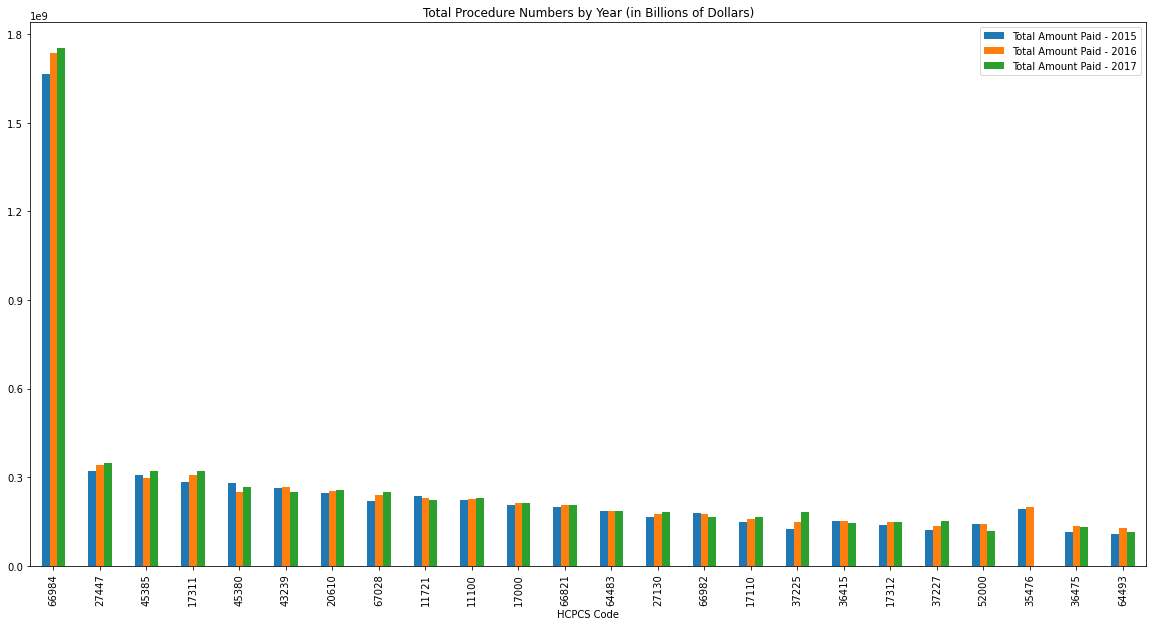

In [7]:
# What surgical procedures, overall, cost Medicare the most?

amount_paid_columns = ['Total Amount Paid - 2015', 'Total Amount Paid - 2016', 'Total Amount Paid - 2017']
df_amount_paid = sort_by_total(df, amount_paid_columns, 'Total Amount Paid')

y_axis = np.arange(0,1800000001, 300000000)
df_amount_paid[0:24].plot.bar(
    x = "HCPCS Code", 
    title = "Total Procedure Numbers by Year (in Billions of Dollars)", 
    yticks = y_axis, 
    figsize = (20, 10)
)

df_amount_paid[0:24].style.hide_index()

HCPCS Code,Code Description,Total Cost to Patient - 2015,Total Cost to Patient - 2016,Total Cost to Patient - 2017
66984,Removal of cataract with insertion of lens,483751039.230000,504891374.340000,516343284.440000
27447,Repair of knee joint,92787111.860000,99504342.400000,101351144.590000
20610,Aspiration and/or injection of large joint or joint capsule,87774368.130000,92582061.290000,95765611.040000
45385,Removal of polyps or growths of large bowel using an endoscope,90404635.970000,88713125.300000,95968227.040000
11721,Removal of tissue from 6 or more finger or toe nails,91182320.360000,91360431.560000,91702739.350000
17311,"Removal and microscopic examination of growth of the head, neck, hands, feet, or genitals (first stage, up to 5 tissue blocks)",84093215.300000,91968656.660000,96418535.670000
17000,Destruction of skin growth,83648772.710000,89165225.820000,92500728.400000
11100,Biopsy of single growth of skin and/or tissue,80890992.510000,87590300.720000,92471641.390000
43239,"Biopsy of the esophagus, stomach, and/or upper small bowel using an endoscope",79975645.720000,81554539.500000,77618772.190000
45380,Biopsy of large bowel using an endoscope,83210704.980000,75624503.590000,80214926.880000


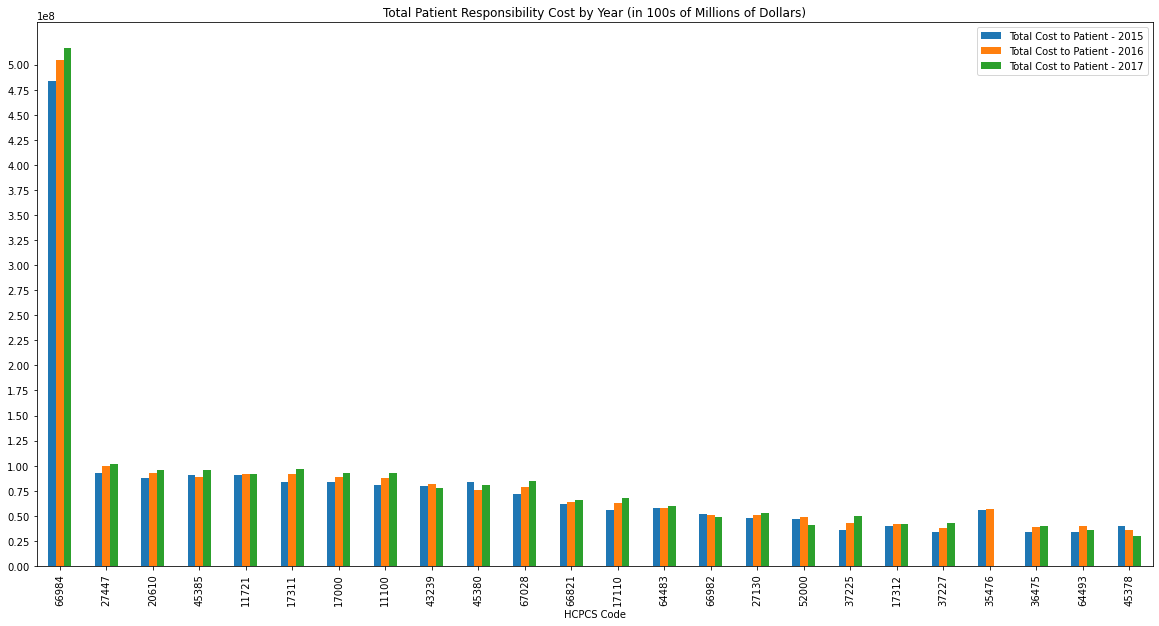

In [8]:
# What procedures were least covered (i.e. where discrepancy between charges and amount paid was greatest).

total_cost_columns = ['Total Cost to Patient - 2015', 'Total Cost to Patient - 2016', 'Total Cost to Patient - 2017']
df_by_cost = sort_by_total(df, total_cost_columns, 'Total Cost to Patient')

y_axis = np.arange(0,500000001, 25000000)
df_by_cost[0:24].plot.bar(
    x = "HCPCS Code", 
    title = "Total Patient Responsibility Cost by Year (in 100s of Millions of Dollars)", 
    yticks = y_axis, 
    figsize = (20, 10)
)

df_by_cost[0:24].style.hide_index()

In [9]:
# Also want to plot out highest average cost to patient and to Medicare.

In [ ]:
# What are the biggest trends and changes from year to year?

In [ ]:
# What types of procedures are most common (can organize by specialty or by surgery method, etc.)
